In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set()
matplotlib.rcParams.update({"font.size": 22})

blues = sns.color_palette("Blues")
oranges = sns.color_palette("Oranges")

# Heavside

$H(x) = \begin{cases} 1 & if x \geq 0 \\ 0 & if x<0 \end{cases}$

$ x = \theta + w $

$ w \sim \mathcal{N}(0, \sigma) \Rightarrow x \sim \mathcal{N}(\theta, \sigma)$

$ \begin{align} \mathbb{E}_w [H(x)] &= \int_{-\infty}^{\infty} H(x) p_\theta(x) dx \\
&= \int_0^{\infty} p_\theta(x) dx \\
& = \int_0^{\infty} \dfrac{1}{\sqrt{2 \pi}\sigma} \exp{\Big(-\dfrac{1}{2} \dfrac{(x-\theta)^2}{\sigma^2}\Big)} dx \\
& = \dfrac{1}{2}\big(erf(\dfrac{\theta}{\sigma \sqrt{2}}) +1\big)
\end{align}$

where the error function is defined as $erf(z) = \dfrac{2}{\pi} \int_0^z e^{-t^2}dt$

$ \begin{align}
\nabla_\theta \mathbb{E} [H(x)] &= \nabla_\theta \dfrac{1}{2} erf \Big( \dfrac{\theta}{\sigma \sqrt{2}} \Big) \\
&= \dfrac{1}{2} \dfrac{2}{\sqrt{\pi}} \exp{\Big( -\dfrac{1}{2} \dfrac{\theta^2}{\sigma^2} \Big)} \dfrac{1}{\sigma \sqrt{2}} \\
&= \dfrac{1}{\sqrt{2\pi} \sigma} \exp{\Big(-\dfrac{1}{2} \dfrac{\theta^2}{\sigma^2} \Big)} 
\end{align}$

In [14]:
# used for ZOBG
def H(x):
    out = np.zeros_like(x)
    out[x>=0] = 1.0
    return out

# used for FOBG
def H_grad(x):
    out = np.zeros_like(x)
    out[out==0.0] == np.inf
    return out

# Gradient of expectation of H
def grad_expect_H(x, sigma):
    return 1/sigma/np.sqrt(2*np.pi)*np.exp(-0.5*(x**2/sigma**2))

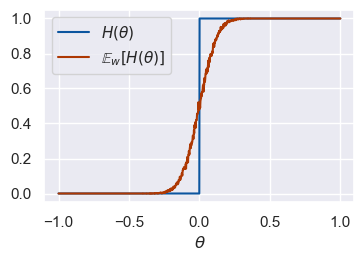

In [15]:
# Plot the function and its smooth version

sigma = 0.1
N = 1000
np.random.seed(0)

plt.figure(figsize=(4,2.5))

# Raw data sample
theta = np.linspace(-1,1, 1000)
plt.plot(theta, H(theta), c=blues[-1], label=r"$H(\theta)$")

# now sample with noise
yy = np.zeros_like(theta)
for i in range(len(yy)):
    w = np.random.normal(0.0, sigma, N)
    yy[i] = np.mean(H(theta[i]+w))
plt.plot(xx, yy, c=oranges[-1], label=r"$\mathbb{E}_w [H(\theta)]$")
plt.legend()
plt.xlabel(r"$\theta$")
# plt.tight_layout()
plt.savefig("heaviside.pdf", bbox_inches='tight')

In [ ]:
# Plot the gradients 

np.random.seed(0)
N = 1000
sigma = 0.1

th = np.linspace(-1,1, 1000)
baseline = H(th)
zobg = np.zeros_like(th)
fobg = np.zeros_like(th)
true_grad = grad_expect_H(th, sigma)

for i, t in enumerate(th):
    w = np.random.normal(0.0, sigma, N)
    zobg[i] = np.mean(1/sigma**2 * (H(t+w) - baseline[i])*w)
    fobg[i] = np.mean(H_grad(t+w))

plt.plot(th, zobg, lw=2, label="ZOBG")
plt.plot(th, fobg, lw=2, label="FOBG")
plt.plot(th, true_grad, lw=2, label=r"$\nabla \mathbb{E}[H(a)]$")
plt.legend()
plt.xlabel(r"$\theta$")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.82it/s]


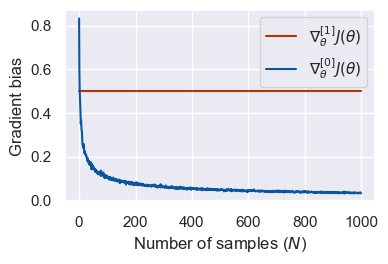

In [136]:
# Plot gradient bias vs number of samples

np.random.seed(0)

# True gradients
true_grad = grad_expect_H(xx, sigma)
baseline = H(xx)

plt.figure(figsize=(4,2.5))

# ZOBG gradient estimation
zobg_bias = np.zeros(N)
fobg_bias = np.zeros(N)
for n in tqdm(range(1,N+1)):
    zobg = np.zeros_like(xx)
    fobg = np.zeros_like(xx)
    for i in range(len(xx)):
        w = np.random.normal(0.0, sigma, n)
        zobg[i] = np.mean(1/sigma**2 * (H(xx[i]+w) - baseline[i])*w)
        fobg[i] = np.mean(H_grad(xx[i]+w))
    zobg_bias[n-1] = np.mean(np.abs(zobg - true_grad))
    fobg_bias[n-1] = np.mean(np.abs(fobg - true_grad))

plt.plot(np.arange(N), fobg_bias, c=oranges[-1], label=r"$\nabla_{\theta}^{[1]} J(\theta)$")
plt.plot(np.arange(N), zobg_bias, c=blues[-1], label=r"$\nabla_{\theta}^{[0]} J(\theta)$")
plt.legend()
plt.xlabel(r"Number of samples ($N$)")
plt.ylabel(r"Gradient bias")
plt.savefig("heaviside_bias.pdf", bbox_inches='tight')

# Soft Heaviside

$\bar{H}(x) = \begin{cases} 1 & x > \dfrac{v}{2} \\
\dfrac{2x}{v} & |x| \leq \dfrac{v}{2} \\
-1 & x < -\dfrac{v}{2} \end{cases}$

$ x = \theta + w $

$ w \sim \mathcal{N}(0, \sigma) \Rightarrow x \sim \mathcal{N}(\theta, \sigma)$

In [5]:
from scipy.special import erf

def H(x, v):
    out = 2*x/v
    out[x<-v/2] = -1
    out[x>v/2] = 1
    return out

def H_grad(xx, v, sigma):
    return 1/sigma/np.sqrt(2*np.pi) * np.exp(-np.power((v/2 - xx),2))

def H_grad2(x, v):
    out = np.ones_like(x)*2/v
    out[x<-v/2] = 0
    out[x>v/2] = 0
    return out

def H_true_grad(x,v,sigma):
    a = 1/np.sqrt(2*np.pi)/sigma *np.exp(-(2*x+v)**2/8/sigma**2) + 1/np.sqrt(2*np.pi)/sigma *np.exp(-(-2*x+v)**2/8/sigma**2)
    b = 1/v * erf((v-2*x)/2/np.sqrt(2)/sigma)
    c = 1/v * erf((v+2*x)/2/np.sqrt(2)/sigma)
    d = -1/v/sigma*np.sqrt(2/np.pi) * x * np.exp(-(v-2*x)**2/8/sigma**2)
    e = 1/v/sigma*np.sqrt(2/np.pi) * x * np.exp(-(v+2*x)**2/8/sigma**2)
    f = -np.sqrt(1/2/np.pi)/sigma/v *np.exp(-(v-2*x)**(1/4/sigma**2)) * (v-2*x)**(1/4/sigma**2-1)
    j = -np.sqrt(1/2/np.pi)/sigma/v *np.exp(-(v+2*x)**(1/4/sigma**2)) * (v+2*x)**(1/4/sigma**2-1)
    return a #+b +c + d + e + f + j

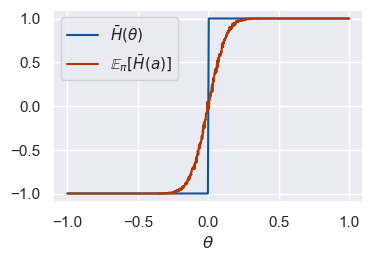

In [6]:
v=0.005
sigma = 0.1
N = 1000
np.random.seed(0)

plt.figure(figsize=(4,2.5))

# Raw data sample
xx = np.linspace(-1,1, 1000)
plt.plot(xx, H(xx,v), c=blues[-1], label=r"$\bar{H}(\theta)$")

# now sample with noise
yy = np.zeros_like(xx)
for i in range(len(yy)):
    w = np.random.normal(0.0, sigma, N)
    yy[i] = np.mean(H(xx[i]+w, v))
plt.plot(xx, yy, c=oranges[-1], label=r"$\mathbb{E}_\pi [ \bar{H}(a)]$")
plt.legend()
plt.xlabel(r"$\theta$")
# plt.tight_layout()
plt.savefig("soft_heaviside.pdf", bbox_inches='tight')

/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_24144/2324296492.py:25: RuntimeWarning: invalid value encountered in double_scalars
  j = -np.sqrt(1/2/np.pi)/sigma/v *np.exp(-(v+2*x)**(1/4/sigma**2)) * (v+2*x)**(1/4/sigma**2-1)
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_24144/2324296492.py:24: RuntimeWarning: invalid value encountered in double_scalars
  f = -np.sqrt(1/2/np.pi)/sigma/v *np.exp(-(v-2*x)**(1/4/sigma**2)) * (v-2*x)**(1/4/sigma**2-1)


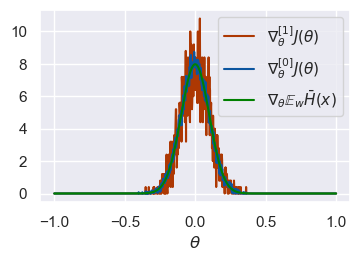

In [7]:
np.random.seed(0)
N = 1000

plt.figure(figsize=(4,2.5))

th = np.linspace(-1,1, 1000)
baseline = H(th, v)
zobg = np.zeros_like(th)
fobg = np.zeros_like(th)
true_grad = np.zeros_like(th)

for i, t in enumerate(th):
    w = np.random.normal(0.0, sigma, N)
    zobg[i] = np.mean(1/sigma**2 * (H(t+w, v) - baseline[i])*w)
    fobg[i] = np.mean(H_grad2(t+w, v))
    true_grad[i] = H_true_grad(t, v, sigma)

plt.plot(th, fobg, c=oranges[-1], label=r"$\nabla_{\theta}^{[1]} J(\theta)$")
plt.plot(th, zobg, c=blues[-1], label=r"$\nabla_{\theta}^{[0]} J(\theta)$")
plt.plot(th, true_grad, c="green", label=r"$\nabla_\theta \mathbb{E}_w{\bar{H}(x)}$")
plt.legend()
plt.xlabel(r"$\theta$")
plt.savefig("soft_heaviside_grad.pdf", bbox_inches='tight')

/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_24144/2324296492.py:24: RuntimeWarning: invalid value encountered in power
  f = -np.sqrt(1/2/np.pi)/sigma/v *np.exp(-(v-2*x)**(1/4/sigma**2)) * (v-2*x)**(1/4/sigma**2-1)
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_24144/2324296492.py:25: RuntimeWarning: invalid value encountered in power
  j = -np.sqrt(1/2/np.pi)/sigma/v *np.exp(-(v+2*x)**(1/4/sigma**2)) * (v+2*x)**(1/4/sigma**2-1)
100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.91it/s]


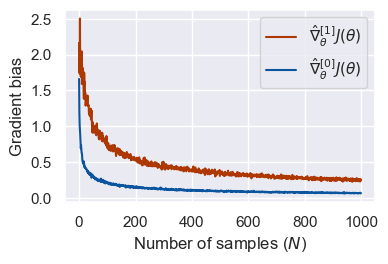

In [12]:
np.random.seed(0)

N = 1000

# True gradients
true_grad = H_true_grad(xx, v, sigma)
baseline = H(xx, v)

plt.figure(figsize=(4,2.5))

# ZOBG gradient estimation
zobg_bias = np.zeros(N)
fobg_bias = np.zeros(N)
zobg_var = np.zeros(N)
fobg_var = np.zeros(N)
for n in tqdm(range(1,N+1)):
    zobg = np.zeros_like(xx)
    fobg = np.zeros_like(xx)
    for i in range(len(xx)):
        w = np.random.normal(0.0, sigma, n)
        zobg[i] = np.mean(1/sigma**2 * (H(xx[i]+w,v) - baseline[i])*w)
        fobg[i] = np.mean(H_grad2(xx[i]+w, v))
    zobg_bias[n-1] = np.mean(np.abs(zobg - true_grad))
    zobg_var[n-1] = np.var(zobg)
    fobg_bias[n-1] = np.mean(np.abs(fobg - true_grad))
    fobg_var[n-1] = np.var(fobg)

plt.plot(np.arange(N), fobg_bias, c=oranges[-1], label=r"$\hat{\nabla}_{\theta}^{[1]} J(\theta)$")
plt.plot(np.arange(N), zobg_bias, c=blues[-1], label=r"$\hat{\nabla}_{\theta}^{[0]} J(\theta)$")
plt.legend()
plt.xlabel(r"Number of samples ($N$)")
plt.ylabel("Gradient bias")
# plt.tight_layout()
plt.savefig("soft_heaviside_bias.pdf", bbox_inches='tight')

/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_24144/2324296492.py:24: RuntimeWarning: invalid value encountered in power
  f = -np.sqrt(1/2/np.pi)/sigma/v *np.exp(-(v-2*x)**(1/4/sigma**2)) * (v-2*x)**(1/4/sigma**2-1)
/var/folders/cj/888lfvn14_38zynpt2hh94yw0000gn/T/ipykernel_24144/2324296492.py:25: RuntimeWarning: invalid value encountered in power
  j = -np.sqrt(1/2/np.pi)/sigma/v *np.exp(-(v+2*x)**(1/4/sigma**2)) * (v+2*x)**(1/4/sigma**2-1)
100it [00:02, 37.33it/s]


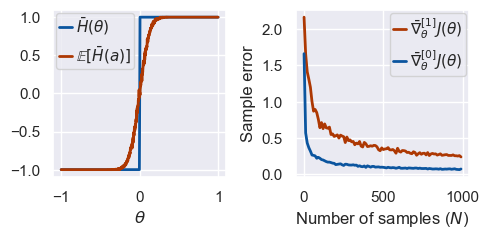

In [10]:
# same as above but combined into 1

f, (ax1, ax2) = plt.subplots(1,2, figsize=(5,2.5))

sigma = 0.1
v=0.005
N = 1000
xx = np.linspace(-1,1, 1000)

np.random.seed(0)

# Raw data sample
xx = np.linspace(-1,1, 1000)
ax1.plot(xx, H(xx,v), lw=2, c=blues[-1], label=r"$\bar{H}(\theta)$")

# now sample with noise
yy = np.zeros_like(xx)
for i in range(len(yy)):
    w = np.random.normal(0.0, sigma, N)
    yy[i] = np.mean(H(xx[i]+w, v))
ax1.plot(xx, yy, lw=2, c=oranges[-1], label=r"$\mathbb{E} [\bar{H}(a)]$")
# ax1.set_xlim((-0.6, 0.6))
ax1.legend(handlelength=0.8, handletextpad=0.3, borderaxespad=0.2,borderpad=0.2)
ax1.set_xlabel(r"$\theta$")

np.random.seed(0)

# True gradients
true_grad = H_true_grad(xx, v, sigma)
baseline = H(xx, v)

# ZOBG gradient estimation
step = 10
zobg_bias = np.zeros(N//step)
fobg_bias = np.zeros(N//step)
zobg_var = np.zeros(N//step)
fobg_var = np.zeros(N//step)
for j, n in tqdm(enumerate(range(1,N+1, step))):
    zobg = np.zeros_like(xx)
    fobg = np.zeros_like(xx)
    for i in range(len(xx)):
        w = np.random.normal(0.0, sigma, n)
        zobg[i] = np.mean(1/sigma**2 * (H(xx[i]+w,v) - baseline[i])*w)
        fobg[i] = np.mean(H_grad2(xx[i]+w, v))
    zobg_bias[j] = np.mean(np.abs(zobg - true_grad))
    zobg_var[j] = np.var(zobg)
    fobg_bias[j] = np.mean(np.abs(fobg - true_grad))
    fobg_var[j] = np.var(fobg)

ax2.plot(np.arange(N, step=step), fobg_bias, lw=2, c=oranges[-1], label=r"$\bar{\nabla}_{\theta}^{[1]} J(\theta)$")
ax2.plot(np.arange(N, step=step), zobg_bias, lw=2, c=blues[-1], label=r"$\bar{\nabla}_{\theta}^{[0]} J(\theta)$")
ax2.legend(handlelength=0.8, handletextpad=0.3, borderaxespad=0.2, borderpad=0.2)
ax2.set_xlabel(r"Number of samples ($N$)")
ax2.set_ylabel("Sample error")
plt.tight_layout(pad=0.5)
plt.savefig("soft_heaviside_combined.pdf", bbox_inches='tight')